In [7]:
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import matplotlib.pyplot as plt
import datetime
import utils
from matplotlib.colors import from_levels_and_colors

In [4]:
datetime_now=datetime.datetime.utcnow()

time, snow = utils.get_snow_data(datetime_now)
# Snow is shape (6, 909, 671), previous 6 hours

lons, lats = utils.get_coords()

'15 Jan 2019, 12 UTC'

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=5.3772,47.1597,15.6116,55.0632&bboxSR=4326&imageSR=4326&size=500,386&dpi=96&format=png32&transparent=true&f=image


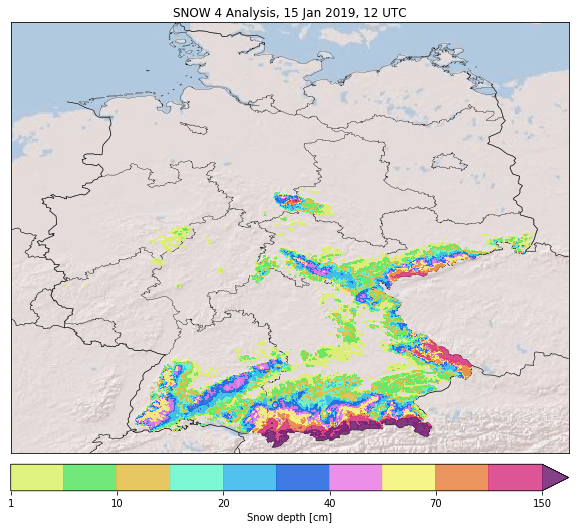

In [23]:
fig = plt.figure(figsize=(10,10))

m = Basemap(projection='cyl', llcrnrlon=lons.min(), llcrnrlat=lats.min(),\
               urcrnrlon=lons.max(), urcrnrlat=lats.max(),  resolution='i')
x, y = m(lons,lats)

levels_snow = (1, 5, 10, 15, 20, 30, 40, 50, 70, 90, 150)

colors = ["#DBF069","#5AE463","#E3BE45","#65F8CA","#32B8EB","#1D64DE","#E97BE4","#F4F476","#E78340","#D73782","#702072"]
cmap_snow, norm_snow = from_levels_and_colors(levels_snow, colors, extend='max')

img=m.arcgisimage(service='World_Shaded_Relief', xpixels = 500, verbose= True)
img.set_alpha(0.8)
m.drawcountries(linewidth=0.6, linestyle='solid', color='black')
m.readshapefile('/home/mpim/m300382/shapefiles/DEU_adm_shp/DEU_adm1','DEU_adm1',
                linewidth=0.2,color='black')

cs = m.contourf(x, y, snow[-1,:,:], levels=levels_snow, cmap=cmap_snow, norm=norm_snow, extend='max',
                alpha=0.85, zorder=4)

plt.colorbar(orientation='horizontal', label='Snow depth [cm]', pad=0.02, fraction=0.05)
plt.title('SNOW 4 Analysis, '+time[-1].strftime('%d %b %Y, %H UTC'))
plt.savefig('hsnow.png', dpi=150, bbox_inches='tight')
plt.show()